In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import math
from datetime import datetime
from sklearn import linear_model

data = pd.read_csv("owid-covid-data.csv") 

data = data[data.iso_code=="RUS"]
data = data[data.date >= '2020-03-03']
data.head(1000)

total = np.array(data.total_cases[0:50])

new = np.array(data.new_cases[0:50])
new = [x if x!=0 else 1 for x in new]


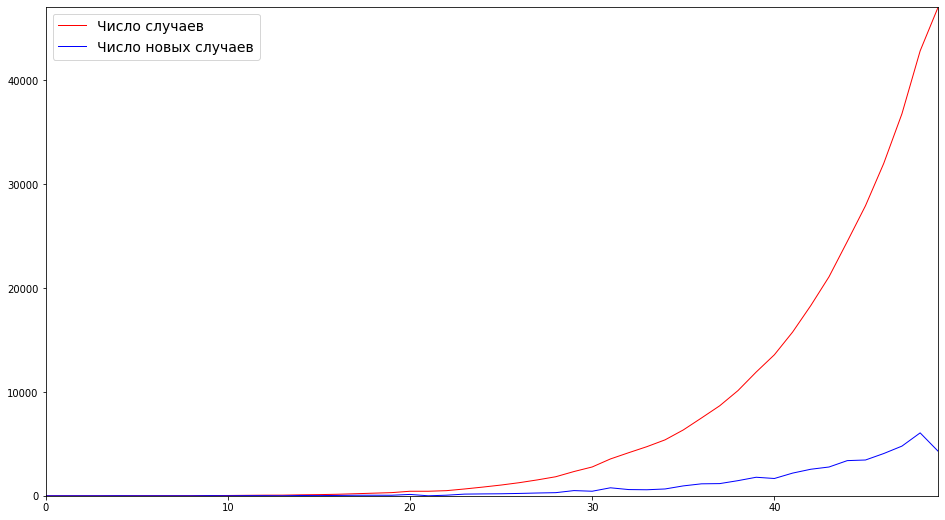

In [135]:
days = np.linspace(0,49,50)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
ax.set_ylim((0, total[-1]))

ax.plot(days, total, linewidth=1, label="Число случаев", color="red")
ax.plot(days, new, linewidth=1, label="Число новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

Будем исходить из априорного распределения параметров y = exp{w0*x + w1} из N(0, a*I). Найдем параметры нормального апостериорного распределения p(w|D)

In [136]:
def create_X_matrix(n):
    t = range(0,2*n)
    t = np.array([ x/2 if x%2==0 else 1 for x in t])
    t= t.reshape(n,2)
    return t

In [159]:
import math

def param_function(a,b,d,N,X,y):
    A = b* (X.transpose()).dot(X) + np.eye(d) * a
    #print(A)
    m = b * np.linalg.inv(A).dot(X.transpose().dot(y))
    #print(m)
    return  .5 * d * math.log(a) \
            + .5*N * math.log(b) \
            - 0.5 * b * np.linalg.norm(y- X.dot(m)) ** 2  \
            - 0.5 * a * np.linalg.norm(m)**2 \
            - 0.5 * math.log(np.linalg.det(A)) 

Оптимизируем параметры a и b исходя из dataset числа заболевших

In [138]:
X = create_X_matrix(50)
total_exp = np.array([math.log(t) for t in total])

param_function(1,1,2,50,X,total_exp)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,total_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)


0.934448160535117 7.443143812709029 16.52761391495929


Найтем математическое ожидание апостериорного распредерения, для этого надо использовать регрессию Лассо с регуляризатором a/b

In [139]:
from sklearn import linear_model

model = linear_model.Lasso(alpha = best_a/best_b, fit_intercept=True).fit(X, total_exp)

print("Среднее апостериорного распределения", model.coef_[0], model.coef_[1],model.intercept_)


Среднее апостериорного распределения 0.20267751811501739 0.0 1.4937265484644708


In [140]:
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Стандартное отклонение апостериорного распределения: 0.34549391102679233


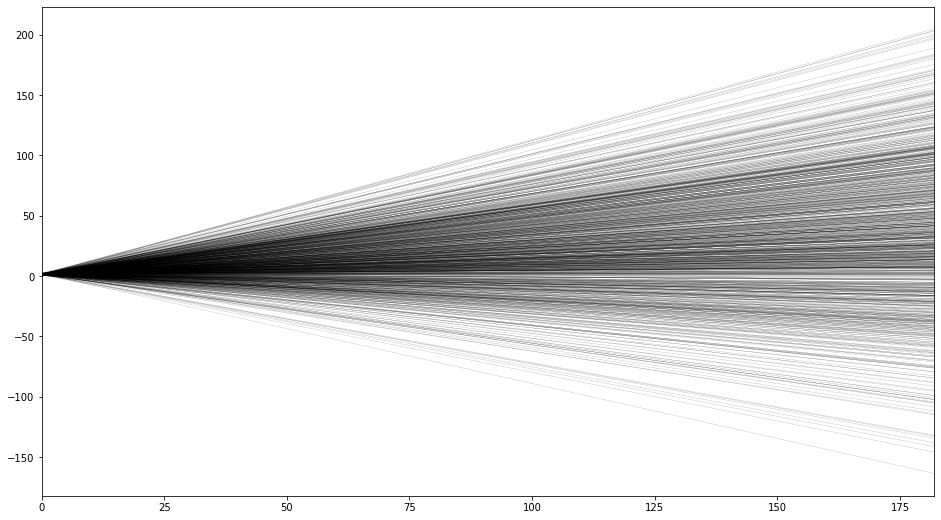

In [141]:
from scipy.stats import multivariate_normal
import datetime

mean = [model.coef_[0], model.intercept_]

def get_sample(mean, std_dev):
     return multivariate_normal.rvs(mean=mean, cov=np.eye(2)*std_dev**2)

days = np.linspace(0,100,101)


start = datetime.date(2020,3,3)
may_1 = (datetime.date(2020,5,1) - start).days
jun_1 = (datetime.date(2020,6,1) - start).days 
sep_1 = (datetime.date(2020,9,1) - start).days 

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
plt.show()


(array([  2.,   5.,   2.,  11.,  10.,  18.,  33.,  60.,  70.,  67., 121.,
        114.,  99.,  83.,  76.,  82.,  52.,  37.,  30.,  13.,   7.,   8.]),
 array([-51.68830102, -46.27857376, -40.86884649, -35.45911923,
        -30.04939196, -24.6396647 , -19.22993743, -13.82021017,
         -8.4104829 ,  -3.00075564,   2.40897163,   7.81869889,
         13.22842616,  18.63815342,  24.04788068,  29.45760795,
         34.86733521,  40.27706248,  45.68678974,  51.09651701,
         56.50624427,  61.91597154,  67.3256988 ]),
 <a list of 22 Patch objects>)

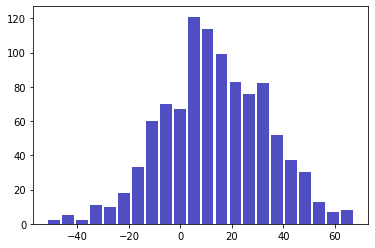

In [142]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 мая')

(array([  2.,   5.,   2.,  11.,   8.,  20.,  32.,  62.,  67.,  69., 121.,
        113.,  99.,  82.,  78.,  82.,  51.,  38.,  30.,  13.,   7.,   8.]),
 array([-79.89563646, -71.62777025, -63.35990405, -55.09203784,
        -46.82417164, -38.55630543, -30.28843923, -22.02057302,
        -13.75270682,  -5.48484061,   2.7830256 ,  11.0508918 ,
         19.31875801,  27.58662421,  35.85449042,  44.12235662,
         52.39022283,  60.65808903,  68.92595524,  77.19382144,
         85.46168765,  93.72955385, 101.99742006]),
 <a list of 22 Patch objects>)

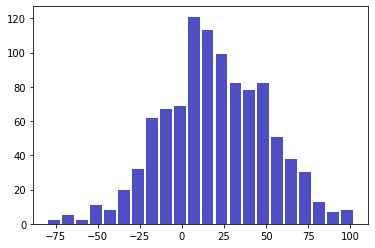

In [143]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 июня')

(array([  1.,   6.,   2.,  11.,   8.,  21.,  30.,  61.,  65.,  72., 119.,
        116.,  98.,  82.,  79.,  82.,  50.,  39.,  29.,  15.,   6.,   8.]),
 array([-163.60772873, -146.85764373, -130.10755873, -113.35747373,
         -96.60738874,  -79.85730374,  -63.10721874,  -46.35713375,
         -29.60704875,  -12.85696375,    3.89312125,   20.64320624,
          37.39329124,   54.14337624,   70.89346123,   87.64354623,
         104.39363123,  121.14371623,  137.89380122,  154.64388622,
         171.39397122,  188.14405621,  204.89414121]),
 <a list of 22 Patch objects>)

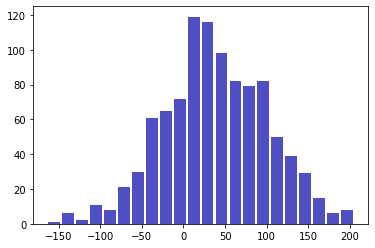

In [144]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 сентября')

Сделаем то же самое для new_cases

In [145]:
X = create_X_matrix(50)
new_exp = np.array([math.log(t) for t in new])

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

36.81571906354515 1.4351170568561873 -20.28557221197176


In [146]:
model = linear_model.Lasso(alpha = best_a/best_b).fit(X, new_exp)

mean = [model.coef_[0], model.intercept_]
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Среднее апостериорного распределения [0.06794348147193136, 2.953479870799395]
Стандартное отклонение апостериорного распределения: 0.16168864949559822


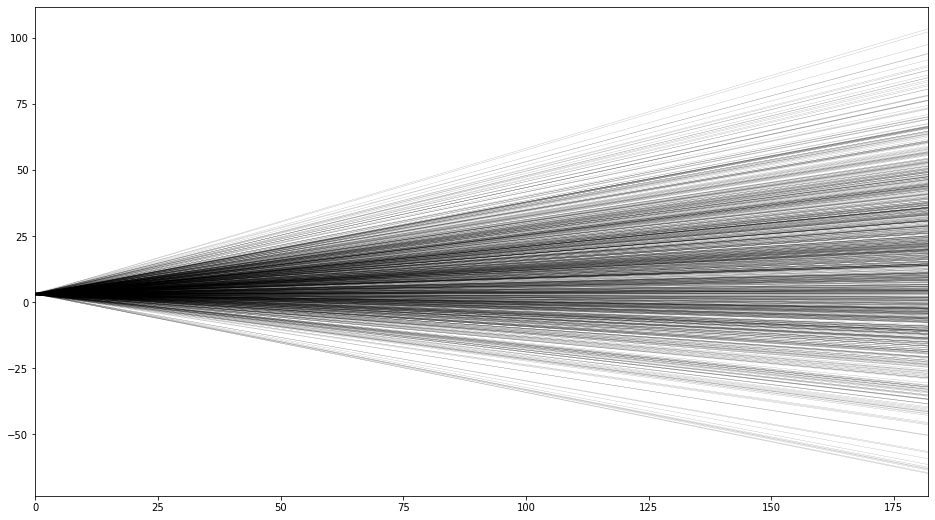

In [147]:
days = np.linspace(0,100,101)

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
plt.show()

(array([ 10.,   2.,  10.,  26.,  24.,  47.,  76.,  99., 106., 102., 113.,
         83.,  90.,  64.,  57.,  32.,  29.,  11.,   9.,   7.,   3.]),
 array([-18.94896431, -16.35668364, -13.76440297, -11.1721223 ,
         -8.57984163,  -5.98756096,  -3.39528029,  -0.80299961,
          1.78928106,   4.38156173,   6.9738424 ,   9.56612307,
         12.15840374,  14.75068442,  17.34296509,  19.93524576,
         22.52752643,  25.1198071 ,  27.71208777,  30.30436845,
         32.89664912,  35.48892979]),
 <a list of 21 Patch objects>)

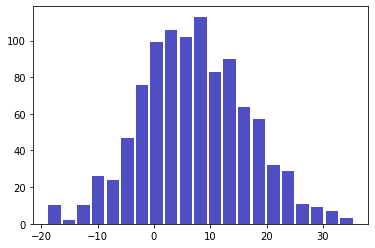

In [148]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 мая')

(array([  8.,   4.,   6.,  21.,  27.,  37.,  63.,  90.,  99., 105.,  87.,
        105.,  80.,  75.,  70.,  42.,  30.,  21.,  12.,  10.,   5.,   3.]),
 array([-30.54725535, -26.76781932, -22.98838329, -19.20894726,
        -15.42951123, -11.6500752 ,  -7.87063917,  -4.09120314,
         -0.31176711,   3.46766892,   7.24710495,  11.02654098,
         14.80597701,  18.58541304,  22.36484907,  26.1442851 ,
         29.92372113,  33.70315716,  37.48259319,  41.26202922,
         45.04146524,  48.82090127,  52.6003373 ]),
 <a list of 22 Patch objects>)

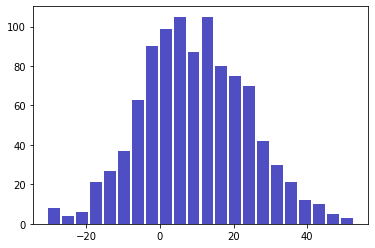

In [149]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 июня')

(array([  8.,   4.,   6.,  21.,  27.,  36.,  62.,  89.,  99., 108.,  86.,
        105.,  83.,  71.,  71.,  44.,  29.,  21.,  11.,  11.,   5.,   3.]),
 array([-64.96799004, -57.31569145, -49.66339286, -42.01109426,
        -34.35879567, -26.70649708, -19.05419849, -11.4018999 ,
         -3.74960131,   3.90269728,  11.55499587,  19.20729446,
         26.85959305,  34.51189165,  42.16419024,  49.81648883,
         57.46878742,  65.12108601,  72.7733846 ,  80.42568319,
         88.07798178,  95.73028037, 103.38257897]),
 <a list of 22 Patch objects>)

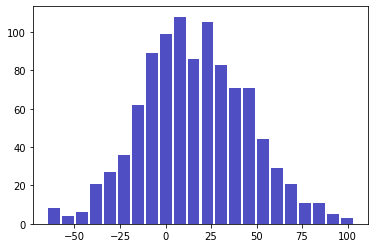

In [150]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 сентября')

## 3.

 Для подбора сигмоиды перейдем от total_cases к new_cases, возьмем логорифм и будем приближать полученные значения регрессией. Действовать будем по аналогии с предыдущим пунктом

In [161]:
x0 = [1 for _ in range(0,50)]
x1 = [i for i in range(0,50)]
x2 = [i*i for i in range(0,50)]

X = np.vstack([x0,x1,x2]).transpose()
print(X)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,3,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

[[   1    0    0]
 [   1    1    1]
 [   1    2    4]
 [   1    3    9]
 [   1    4   16]
 [   1    5   25]
 [   1    6   36]
 [   1    7   49]
 [   1    8   64]
 [   1    9   81]
 [   1   10  100]
 [   1   11  121]
 [   1   12  144]
 [   1   13  169]
 [   1   14  196]
 [   1   15  225]
 [   1   16  256]
 [   1   17  289]
 [   1   18  324]
 [   1   19  361]
 [   1   20  400]
 [   1   21  441]
 [   1   22  484]
 [   1   23  529]
 [   1   24  576]
 [   1   25  625]
 [   1   26  676]
 [   1   27  729]
 [   1   28  784]
 [   1   29  841]
 [   1   30  900]
 [   1   31  961]
 [   1   32 1024]
 [   1   33 1089]
 [   1   34 1156]
 [   1   35 1225]
 [   1   36 1296]
 [   1   37 1369]
 [   1   38 1444]
 [   1   39 1521]
 [   1   40 1600]
 [   1   41 1681]
 [   1   42 1764]
 [   1   43 1849]
 [   1   44 1936]
 [   1   45 2025]
 [   1   46 2116]
 [   1   47 2209]
 [   1   48 2304]
 [   1   49 2401]]
38.65150501672241 1.4351170568561873 -25.1955643343299


In [163]:
model = linear_model.Lasso(alpha = best_a/best_b).fit(X, new_exp)
print(model.coef_)
print(model.intercept_)
mean = [model.intercept_, model.coef_[1], model.coef_[2] ]
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

[0.         0.         0.00350655]
1.7830474898020316
Среднее апостериорного распределения [1.7830474898020316, 0.0, 0.0035065524762642936]
Стандартное отклонение апостериорного распределения: 0.15794295866242705
